# Oxford Study:
Source for the Parameters can be found here: https://www.medrxiv.org/content/10.1101/2021.03.25.21254330v1.full.pdf

Values are approximated from Fig 2. only the medium Values where taken!!

### Calculate the R value vor different covid Measures

In [1]:
from calculateRT import calculateRT
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


In [2]:
phases = ['Free', 'Lockdown']
menus = [calculateRT(name) for name in phases]
items = [m.getWidgetList() for m in menus]
boxes = [widgets.VBox(i) for i in items]

widgets.HBox(boxes)

## Now we need some simulation to actually see what that R Value would do:
For simplicity we will start with a periodic change between beeing in Lockdown and not having a Lockdown.

### Periodic Lockdown function
At the beginning of a lockdown it takes some time for new Measures to have an effect. This will be simulated with an exponential curve in the R value
$$R(t) \propto exp(-\lambda * t)$$

Another function may be more suitable here... I will have to read on this.

In [4]:
from numba import njit
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
from scipy.integrate import odeint
from scipy.integrate import solve_ivp # Besserer Integrator
from CoronaSimulation import CoronaSimulation

In [5]:
@njit
def lockdown(t, partIn, periods, R_values, beta):
    R_in, R_out = R_values
    daysInPeriod = np.mod(t, periods)
    # Positive, if in Lockdown
    daysInLockdown = (daysInPeriod - np.outer(1-partIn, period)).flatten()
    isLockdown = daysInLockdown > 0
    Rs = np.ones(daysInLockdown.shape)
    Rs[isLockdown] = np.exp(-lamda * (daysInLockdown[isLockdown]+1)) + R_in
    Rs[np.logical_not(isLockdown)] = R_out
    return Rs.T*beta

### SIR Modell
For this I use a basic SIR-modell with:
The number of not yet infected Persons
$$\dot x = - \alpha *x*y$$
The number of currently infectuos Persons
$$\dot y = -(\dot x+ \dot z)$$
The number of Persons who are either Imune or Dead (Removed)
$$\dot z = \beta *y$$
The Parameter $\alpha = R * \beta$ will change with the R value described above

In [6]:
@njit
def odes(t, p, alpha_calc, Rts, beta, partIn, period):
    x = p[:l*l]
    y = p[l*l:2*l*l]
    z = p[2*l*l:]
    
    alpha = alpha_calc(t, partIn, period, Rts, beta)
    
    dx = - alpha * x * y
    dz = beta *y
    dy = -(dx+dz)
    
    return np.concatenate((dx,dy,dz))

In [18]:
# Now Slider Menus and start Button
lamda = 0.7
beta = 0.12

#Later: Slider Menus here
l = 100
mindt = 1

#Later: Need Renge Sliders for this
period = np.linspace(1, 100, l, endpoint =True)
partIn = np.linspace(0, 0.9, l, endpoint =True)

# Now: Slider Menus for Starting Parameters
p0_keys = ['N', 'Infected Persons', 'removed Persons']
N = 8.2 * 10**7
infected = 2* 10**5/N
removed = 2.1*10**6/N
notInfected = 1 - infected - removed

matrix = np.ones((l,l))
p0 = np.array([notInfected*matrix, infected*matrix, removed *matrix]).flatten()

Rts = np.array([m.getRvalue() for m in menus])

In [169]:
# Make a simulation object
sim = Co

In [ ]:
#Make the Sliders
slider_keys = ['lambda', 'beta']
slider_values = [0.12, 0.7]
sliders = {}
for k,v in zip(slider_keys, slider_values):
    sliders[k] = widgets.FloatSlider(
            value=v,
            min=0,
            max=1,
            step=0.01,
            description=f'$\\{k}$',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='.1f',
    )
# Make a start Button


### Display the simulated Data
From the data we simulated we can now read some important Figures:
#### Part of the Population, that was at Some time infected with Covid-19
This can be calculated simply by looking at the Part $x$ of the Popultation, that was never infected:
$$N_{\text{infected}} = 1-x(t_{max})$$

In [ ]:
extend=(partIn[-1], partIn[0], period[-1], period[0])

In [ ]:
total_infected = (1-x)[:,:,-1].T
plt.figure(2, (4,4), 300)
plt.imshow(total_infected, extent=extend, aspect='auto')
plt.xlabel("Part of time Spent in Lockdown")
plt.ylabel("Period of Lockdowns")
plt.title("Total infected Part of the Population")
plt.colorbar()

#### Maximum infected part of the Population
The Maximum Number of infected is an important indicator to see if the Healthcare will be overwhelmed. This can be calculatet by looking at the maximum value of the infected persons $y$ over all timesteps:
$$y_{max} = \max_t (y)$$

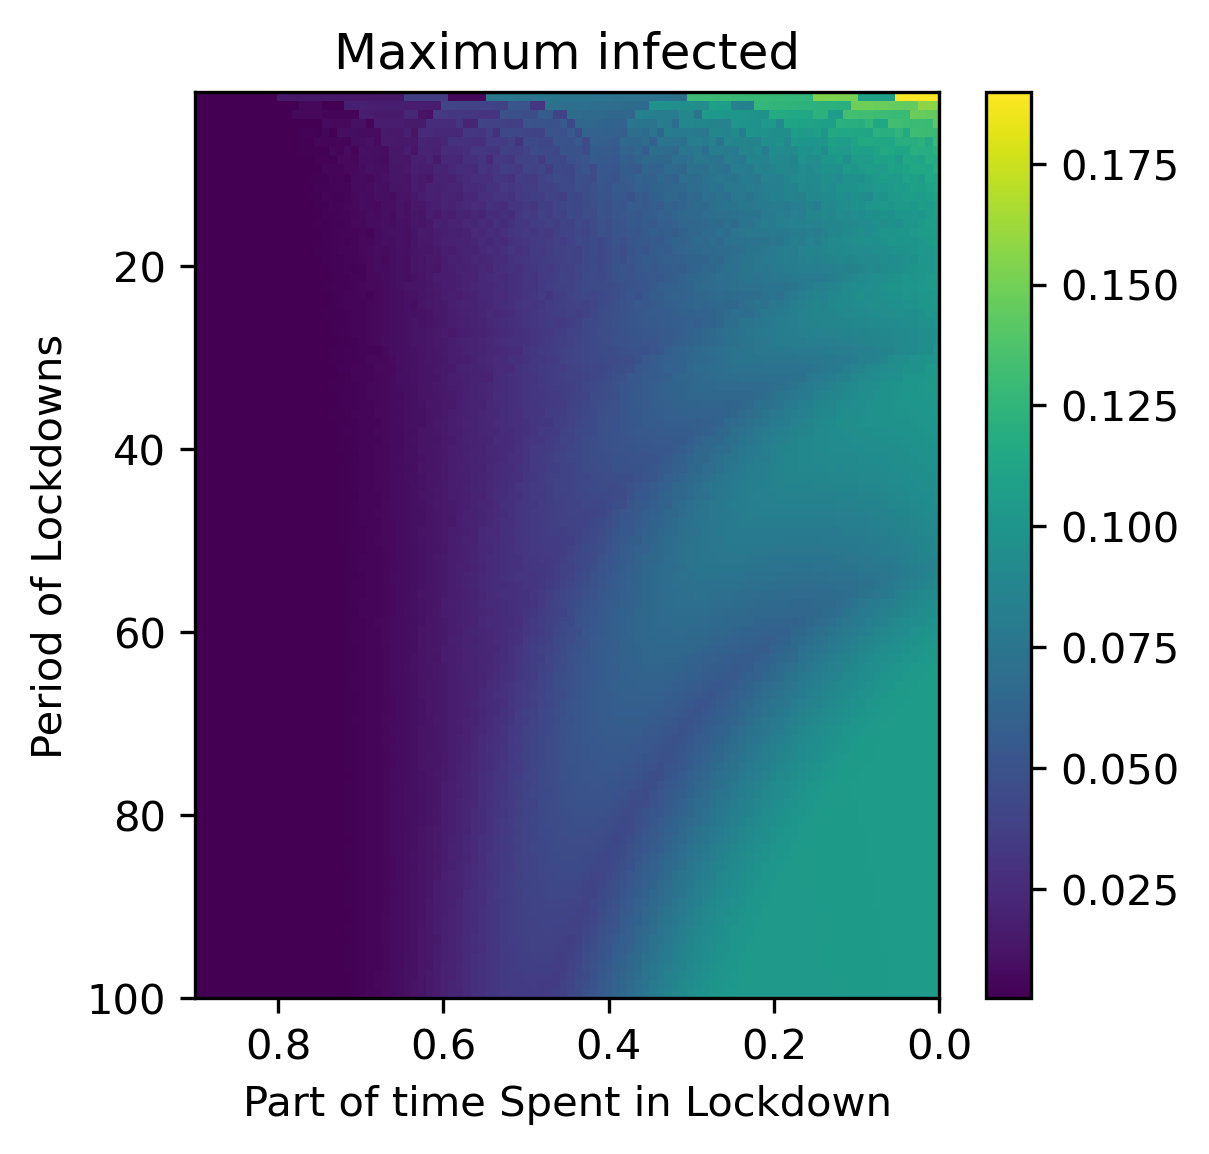

In [142]:
max_infected = np.amax(y, 2).T
plt.figure(1, (4,4), 300)
plt.imshow(max_infected, extent=extend, aspect='auto')
plt.xlabel("Part of time Spent in Lockdown")
plt.ylabel("Period of Lockdowns")
plt.title("Maximum infected")
plt.colorbar()

#### Long Covid
It is estimated, that 10 Percent of the Covid infected suffer from long Covid Symtoms (Citation needed). We can calculate the absolute Number of People sufering these Symptoms, by simply multipling $z$ with that factor $p = 0,1$
$$N_\text{long covid} = 0.1 * z(t_{max})$$

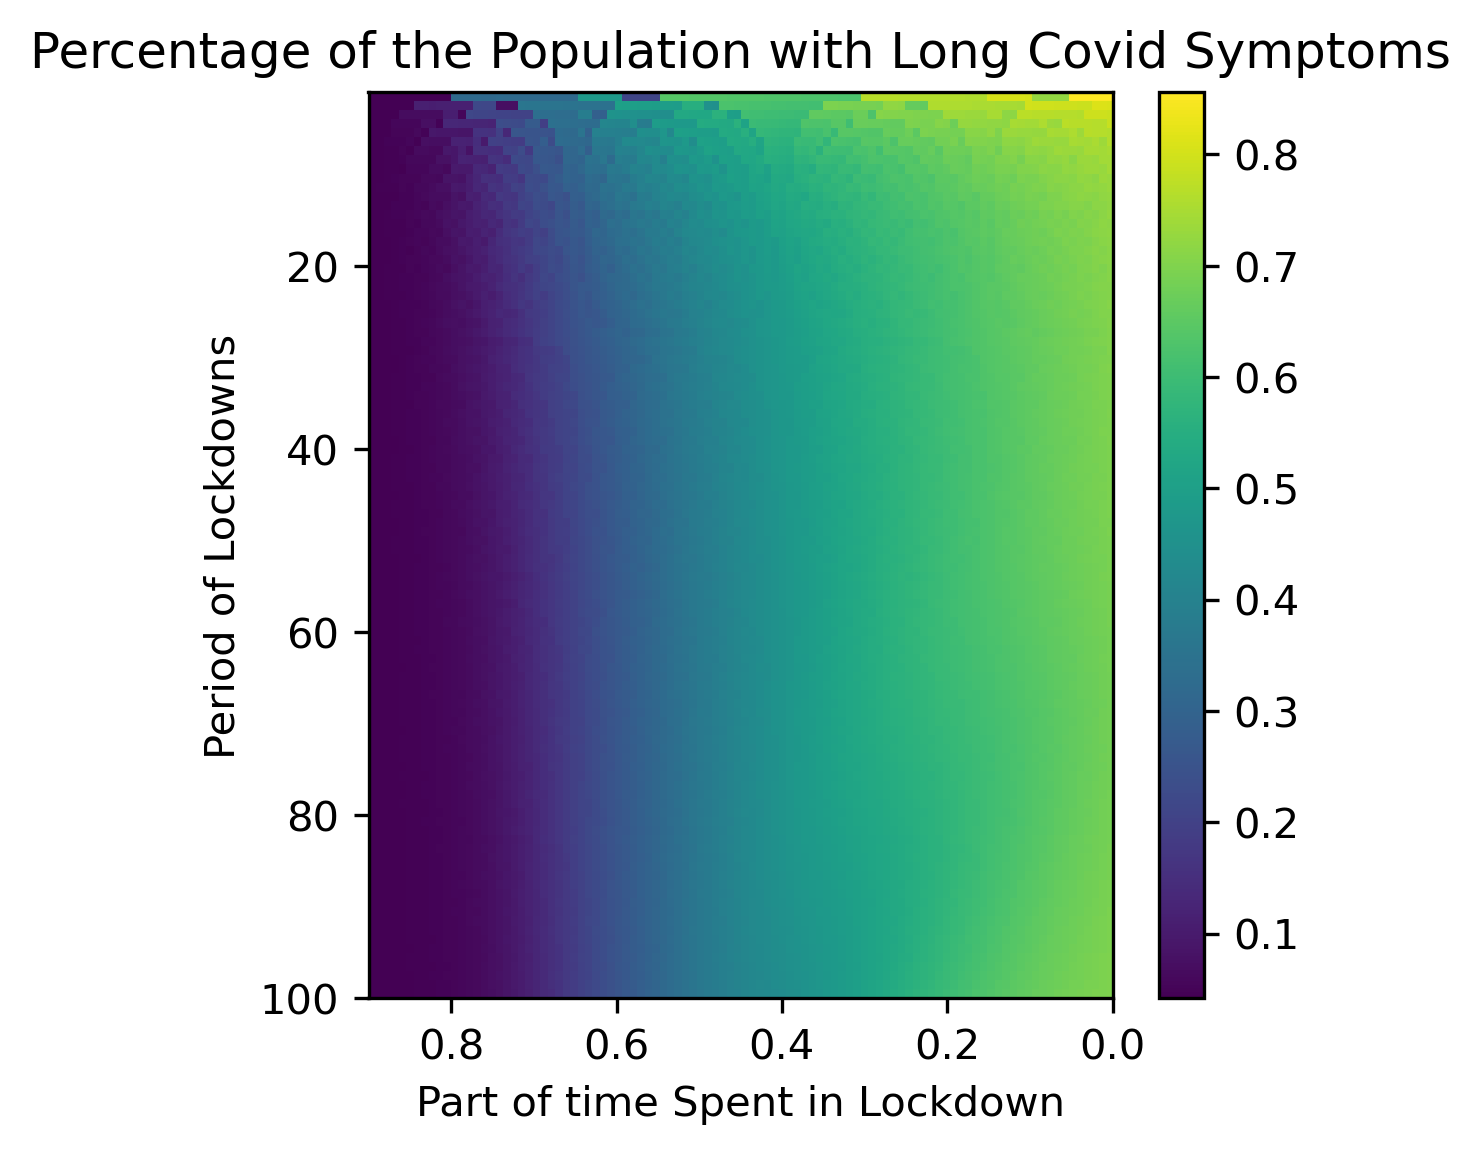

In [139]:
total_longCovid = (1-x)[:,:,-1].T
plt.figure(3, (4,4), 300)
plt.imshow(total_longCovid, extent=extend, aspect='auto')
plt.xlabel("Part of time Spent in Lockdown")
plt.ylabel("Period of Lockdowns")
plt.title("Percentage of the Population with Long Covid Symptoms")
plt.colorbar()